In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'uni90'

In [4]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

text_cols = ["LudRules",]
# text_cols = None

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 326
Categorical features: 10
Text features: 1


In [5]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 398
Categorical Columns: 10


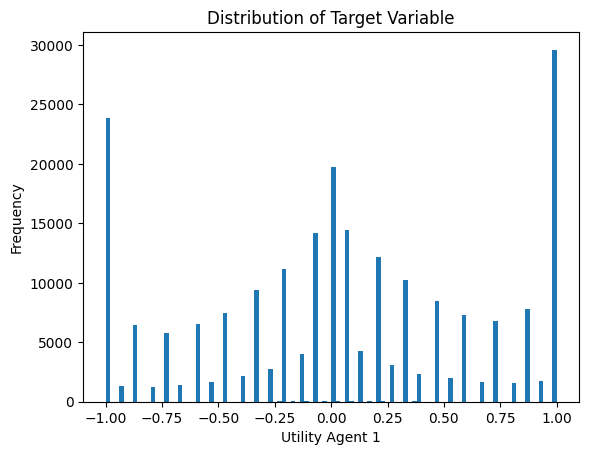

In [6]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [7]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [8]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [9]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols=None,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }


    # below are default params for text processing
    # 'text_processing': {
    #     'tokenizers': [{
    #         'tokenizer_id': 'Space',  # Simple space-based tokenization
    #         'separator_type': 'Space'
    #     }],
    #     'dictionaries': [{
    #         'dictionary_id': 'UniGram',  # Single words/tokens
    #         'max_dictionary_size': '50000',  # Maximum number of unique tokens to keep
    #         'occurrence_lower_bound': '3'  # Minimum number of times a token must appear
    #     }],
    #     'feature_calcers': [{
    #         'calcer_type': 'BoW',  # Bag of Words representation
    #         'dictionary_id': 'UniGram'
    #     }]
    # }


    # if text_cols:
    #     params.update({
    #         'text_processing': {
    #             'tokenizers': [{
    #                 'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
    #                 'separator_type': 'Space'
    #             }],
    #             'dictionaries': [{
    #                 'dictionary_id': 'BiGram',
    #                 'max_dictionary_size': '50000',
    #                 'occurrence_lower_bound': '3',
    #                 'gram_order': '2'
    #             }],
    #             'feature_calcers': [{
    #                 'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
    #                 'dictionary_id': 'BiGram'
    #             }]
    #         }
    #     })

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Prepare feature list
        feature_cols = numerical_cols + categorical_cols
        if text_cols:
            feature_cols += text_cols

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            data=X_train[feature_cols],
            label=y_train,
            cat_features=categorical_cols,
            text_features=text_cols if text_cols else None
        )
        val_pool = cb.Pool(
            data=X_valid[feature_cols],
            label=y_valid,
            cat_features=categorical_cols,
            text_features=text_cols if text_cols else None
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1
0:	learn: 0.6111150	test: 0.5482900	best: 0.5482900 (0)	total: 607ms	remaining: 30m 21s
50:	learn: 0.3836359	test: 0.4628109	best: 0.4628109 (50)	total: 27.5s	remaining: 26m 27s
100:	learn: 0.3474684	test: 0.4465718	best: 0.4465718 (100)	total: 53s	remaining: 25m 22s
150:	learn: 0.3248422	test: 0.4381659	best: 0.4381659 (150)	total: 1m 18s	remaining: 24m 40s
200:	learn: 0.3076152	test: 0.4332381	best: 0.4332381 (200)	total: 1m 43s	remaining: 24m 6s
250:	learn: 0.2951591	test: 0.4300971	best: 0.4300971 (250)	total: 2m 9s	remaining: 23m 37s
300:	learn: 0.2857113	test: 0.4277704	best: 0.4277704 (300)	total: 2m 35s	remaining: 23m 12s
350:	learn: 0.2780933	test: 0.4269411	best: 0.4269243 (349)	total: 3m 1s	remaining: 22m 48s
400:	learn: 0.2713728	test: 0.4258401	best: 0.4258300 (398)	total: 3m 26s	remaining: 22m 21s
450:	learn: 0.2650925	test: 0.4252378	best: 0.4252378 (450)	total: 3m 52s	remaining: 21m 54s
500:	learn: 0.2600360	test: 0.4246490	best: 0.4246097 (496)	total: 4m 18s	rem

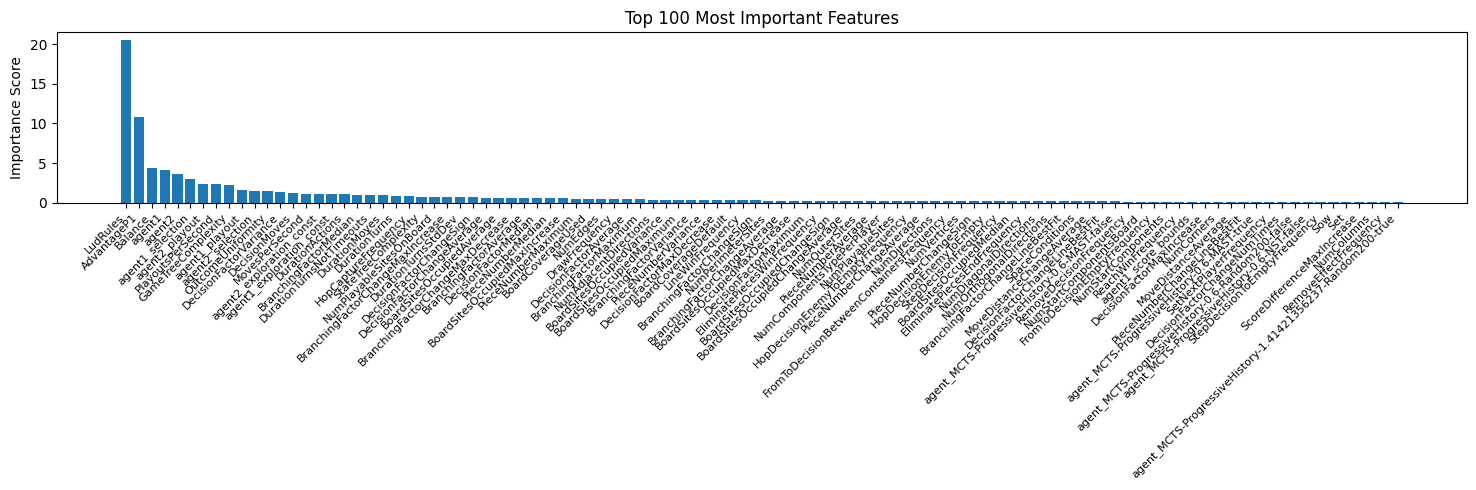

Fold 1 - RMSE: 0.4199652357194457
Fold 2
0:	learn: 0.6038397	test: 0.5828034	best: 0.5828034 (0)	total: 520ms	remaining: 26m
50:	learn: 0.3949350	test: 0.4787552	best: 0.4787010 (46)	total: 28.4s	remaining: 27m 20s
100:	learn: 0.3571946	test: 0.4642200	best: 0.4642200 (100)	total: 56.4s	remaining: 26m 59s
150:	learn: 0.3348269	test: 0.4559732	best: 0.4559732 (150)	total: 1m 23s	remaining: 26m 22s
200:	learn: 0.3201031	test: 0.4527372	best: 0.4527372 (200)	total: 1m 50s	remaining: 25m 34s
250:	learn: 0.3072903	test: 0.4488621	best: 0.4488621 (250)	total: 2m 16s	remaining: 24m 58s
300:	learn: 0.2971110	test: 0.4472705	best: 0.4471685 (298)	total: 2m 43s	remaining: 24m 29s
350:	learn: 0.2885559	test: 0.4461915	best: 0.4460911 (347)	total: 3m 11s	remaining: 24m 8s
400:	learn: 0.2817499	test: 0.4451497	best: 0.4450805 (395)	total: 3m 39s	remaining: 23m 44s
450:	learn: 0.2757907	test: 0.4446396	best: 0.4446065 (449)	total: 4m 6s	remaining: 23m 15s
500:	learn: 0.2705488	test: 0.4440381	best: 

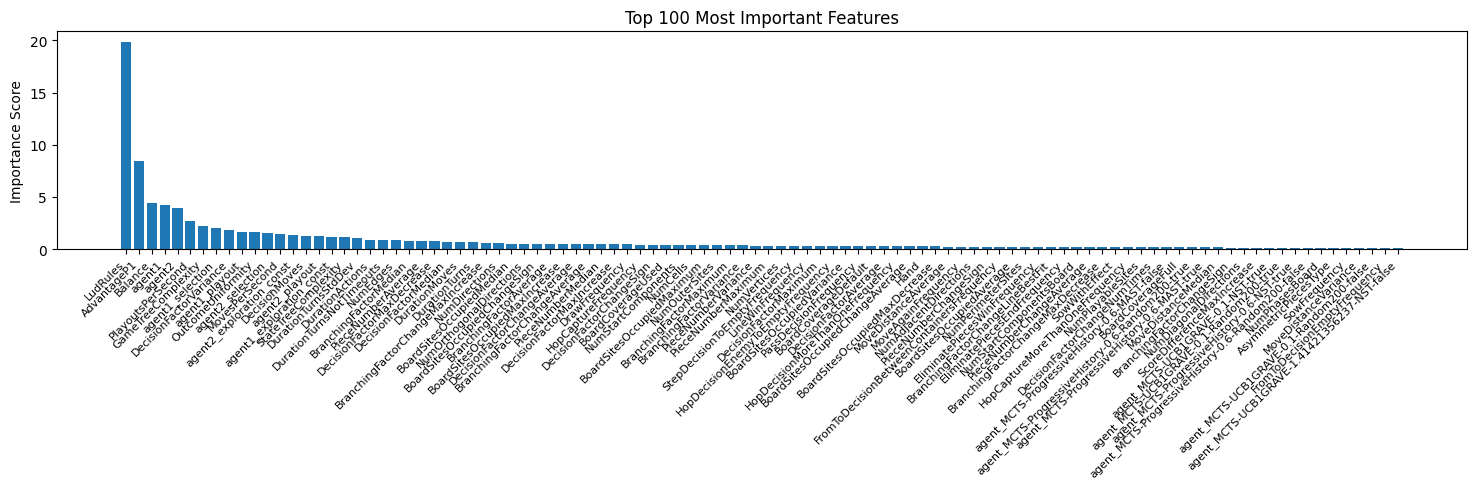

Fold 2 - RMSE: 0.43904755115327887
Fold 3
0:	learn: 0.6010754	test: 0.5952087	best: 0.5952087 (0)	total: 524ms	remaining: 26m 10s
50:	learn: 0.3924582	test: 0.4626699	best: 0.4624888 (49)	total: 28.1s	remaining: 27m 5s
100:	learn: 0.3563800	test: 0.4474998	best: 0.4474998 (100)	total: 55.4s	remaining: 26m 29s
150:	learn: 0.3330652	test: 0.4381635	best: 0.4381635 (150)	total: 1m 22s	remaining: 25m 54s
200:	learn: 0.3169679	test: 0.4335373	best: 0.4335373 (200)	total: 1m 49s	remaining: 25m 22s
250:	learn: 0.3052169	test: 0.4315860	best: 0.4315860 (250)	total: 2m 16s	remaining: 24m 52s
300:	learn: 0.2950680	test: 0.4297388	best: 0.4297388 (300)	total: 2m 43s	remaining: 24m 24s
350:	learn: 0.2868020	test: 0.4279056	best: 0.4279056 (350)	total: 3m 10s	remaining: 23m 57s
400:	learn: 0.2800822	test: 0.4268316	best: 0.4268316 (400)	total: 3m 37s	remaining: 23m 31s
450:	learn: 0.2736668	test: 0.4262697	best: 0.4261278 (442)	total: 4m 5s	remaining: 23m 4s
500:	learn: 0.2680193	test: 0.4256464	be

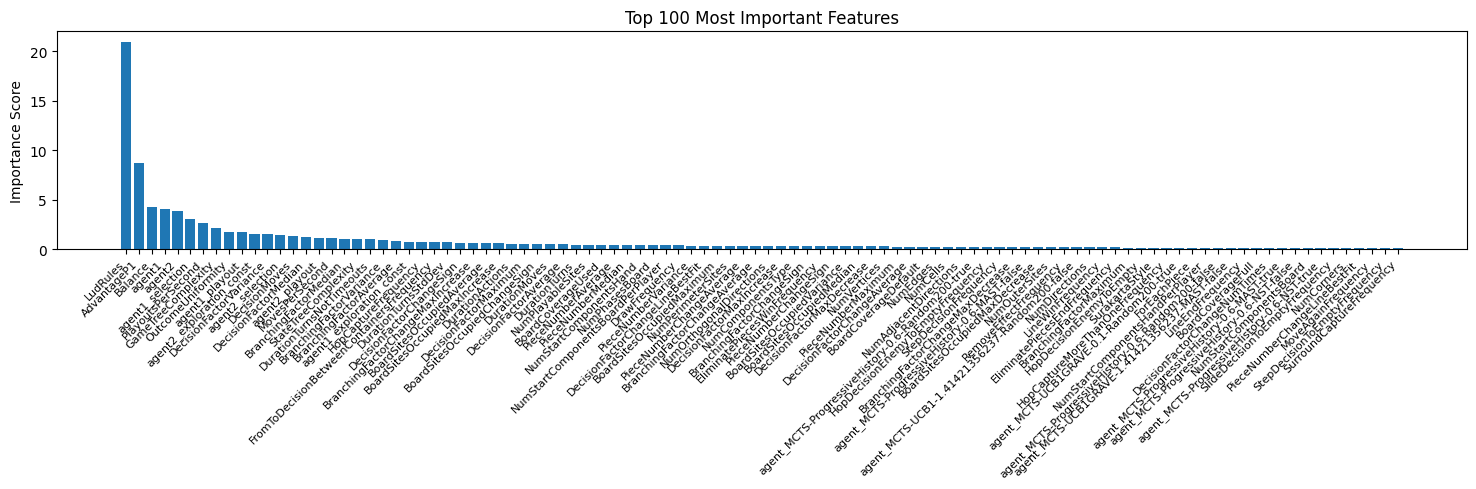

Fold 3 - RMSE: 0.41995674595389715
Fold 4
0:	learn: 0.6025824	test: 0.5902066	best: 0.5902066 (0)	total: 514ms	remaining: 25m 41s
50:	learn: 0.3915775	test: 0.4789096	best: 0.4789096 (50)	total: 27.3s	remaining: 26m 18s
100:	learn: 0.3548935	test: 0.4598191	best: 0.4598191 (100)	total: 55.9s	remaining: 26m 45s
150:	learn: 0.3325470	test: 0.4495988	best: 0.4495936 (149)	total: 1m 23s	remaining: 26m 10s
200:	learn: 0.3156220	test: 0.4441709	best: 0.4441709 (200)	total: 1m 51s	remaining: 25m 46s
250:	learn: 0.3037119	test: 0.4418484	best: 0.4418484 (250)	total: 2m 18s	remaining: 25m 18s
300:	learn: 0.2938357	test: 0.4393464	best: 0.4393464 (300)	total: 2m 46s	remaining: 24m 56s
350:	learn: 0.2848044	test: 0.4377034	best: 0.4376701 (349)	total: 3m 13s	remaining: 24m 21s
400:	learn: 0.2778178	test: 0.4363484	best: 0.4363484 (400)	total: 3m 40s	remaining: 23m 50s
450:	learn: 0.2712808	test: 0.4355980	best: 0.4355626 (449)	total: 4m 9s	remaining: 23m 27s
500:	learn: 0.2654602	test: 0.4350979	

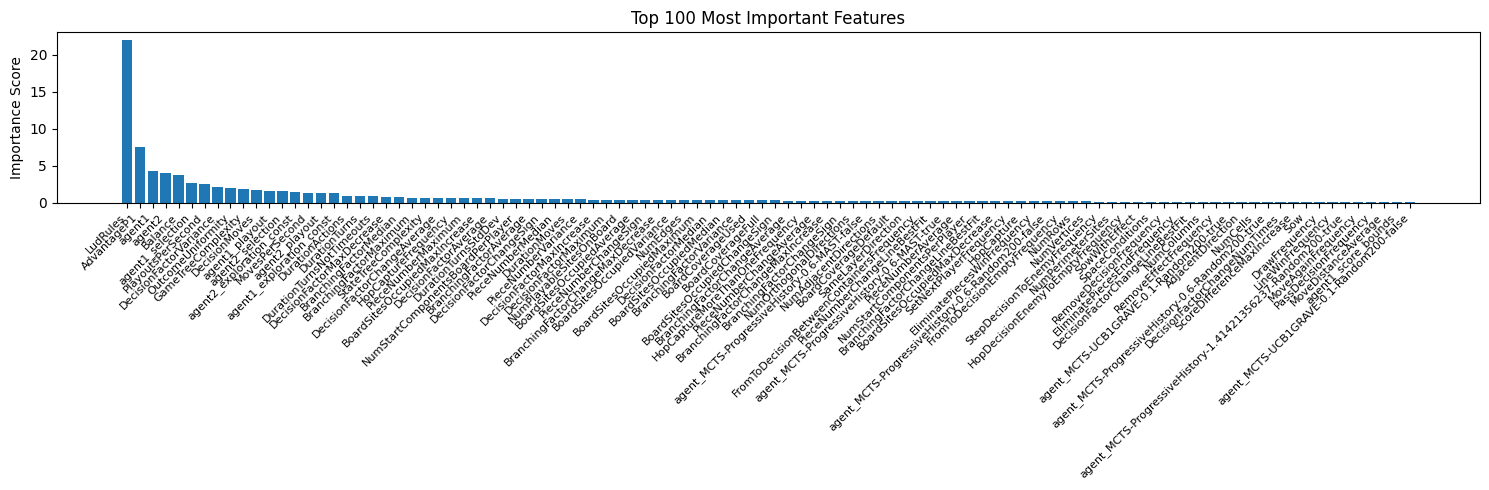

Fold 4 - RMSE: 0.42834028118477635
Fold 5
0:	learn: 0.6141434	test: 0.5420985	best: 0.5420985 (0)	total: 512ms	remaining: 25m 34s
50:	learn: 0.3969939	test: 0.4480674	best: 0.4480674 (50)	total: 27.8s	remaining: 26m 44s
100:	learn: 0.3582876	test: 0.4297218	best: 0.4297218 (100)	total: 55s	remaining: 26m 17s
150:	learn: 0.3339220	test: 0.4201917	best: 0.4201917 (150)	total: 1m 22s	remaining: 25m 53s
200:	learn: 0.3189301	test: 0.4157365	best: 0.4157365 (200)	total: 1m 49s	remaining: 25m 21s
250:	learn: 0.3065629	test: 0.4134931	best: 0.4134931 (250)	total: 2m 16s	remaining: 24m 52s
300:	learn: 0.2975371	test: 0.4124294	best: 0.4123497 (294)	total: 2m 42s	remaining: 24m 21s
350:	learn: 0.2896870	test: 0.4106968	best: 0.4106968 (350)	total: 3m 9s	remaining: 23m 52s
400:	learn: 0.2826075	test: 0.4092335	best: 0.4092335 (400)	total: 3m 36s	remaining: 23m 22s
450:	learn: 0.2759336	test: 0.4081345	best: 0.4080545 (445)	total: 4m 3s	remaining: 22m 56s
500:	learn: 0.2703167	test: 0.4074482	bes

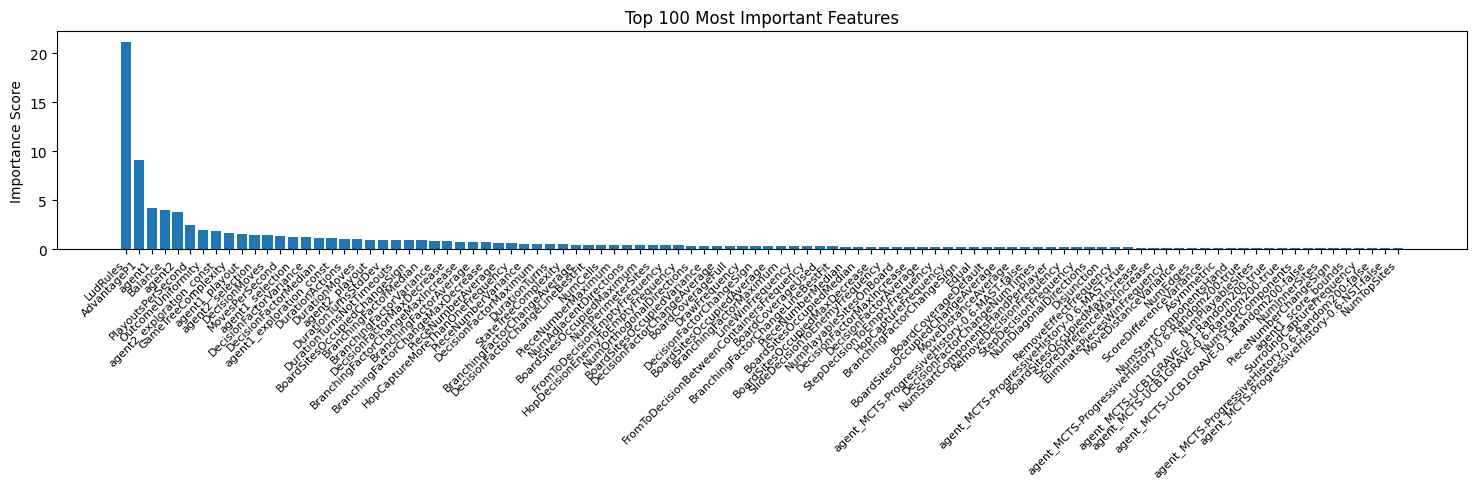

Fold 5 - RMSE: 0.4030697919698375
List of oof scores: [0.4199652357194457, 0.43904755115327887, 0.41995674595389715, 0.42834028118477635, 0.4030697919698375]
Average oof score: 0.4220759211962471


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_text_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1
0:	learn: 0.6162223	test: 0.5296469	best: 0.5296469 (0)	total: 532ms	remaining: 26m 36s
50:	learn: 0.3950211	test: 0.4485577	best: 0.4485577 (50)	total: 30.4s	remaining: 29m 19s
100:	learn: 0.3589352	test: 0.4362677	best: 0.4362677 (100)	total: 59.8s	remaining: 28m 37s
150:	learn: 0.3368259	test: 0.4280369	best: 0.4280369 (150)	total: 1m 29s	remaining: 28m 5s
200:	learn: 0.3215215	test: 0.4243716	best: 0.4243206 (199)	total: 1m 58s	remaining: 27m 36s
250:	learn: 0.3091406	test: 0.4212109	best: 0.4212109 (250)	total: 2m 28s	remaining: 27m 8s
300:	learn: 0.2994870	test: 0.4191381	best: 0.4191381 (300)	total: 2m 58s	remaining: 26m 37s
350:	learn: 0.2910848	test: 0.4180459	best: 0.4179880 (345)	total: 3m 27s	remaining: 26m 8s
400:	learn: 0.2837880	test: 0.4170100	best: 0.4170100 (400)	total: 3m 57s	remaining: 25m 40s
450:	learn: 0.2774779	test: 0.4161901	best: 0.4161901 (450)	total: 4m 27s	remaining: 25m 12s
500:	learn: 0.2717894	test: 0.4145872	best: 0.4145872 (500)	total: 4m 57s	r

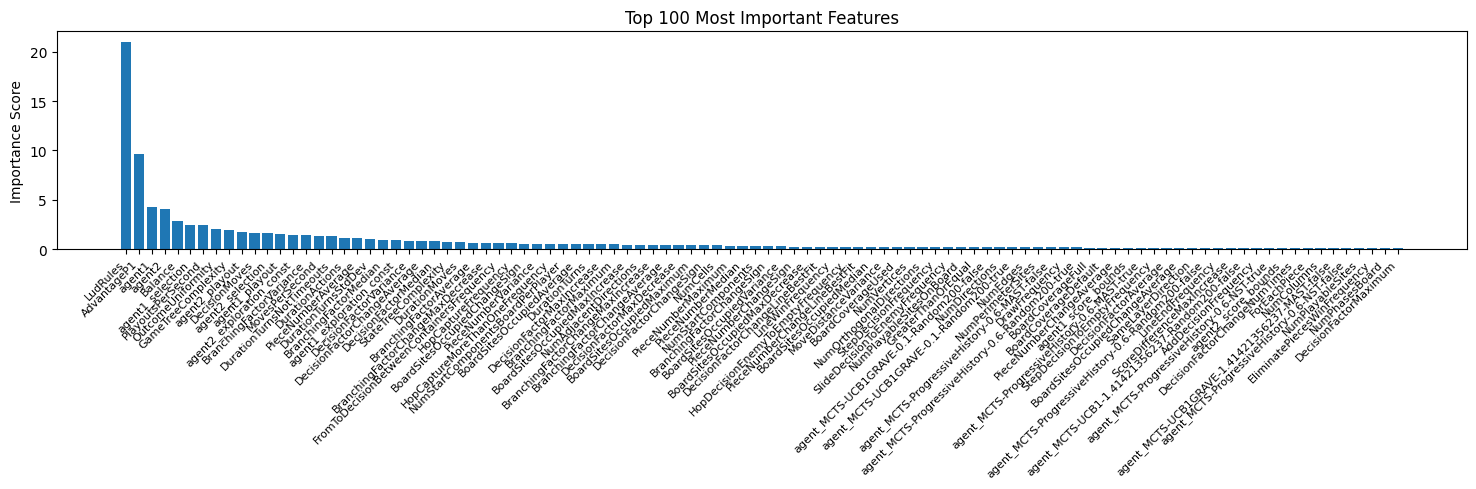

Fold 1 - RMSE: 0.40815936282291454
Fold 2
0:	learn: 0.6155376	test: 0.5397931	best: 0.5397931 (0)	total: 589ms	remaining: 29m 25s
50:	learn: 0.3924852	test: 0.4312757	best: 0.4312757 (50)	total: 30.7s	remaining: 29m 34s
100:	learn: 0.3538230	test: 0.4195424	best: 0.4195424 (100)	total: 1m 1s	remaining: 29m 24s
150:	learn: 0.3299092	test: 0.4126551	best: 0.4126551 (150)	total: 1m 31s	remaining: 28m 48s
200:	learn: 0.3144347	test: 0.4090953	best: 0.4090953 (200)	total: 2m 2s	remaining: 28m 20s
250:	learn: 0.3020043	test: 0.4074854	best: 0.4073622 (239)	total: 2m 32s	remaining: 27m 45s
300:	learn: 0.2926258	test: 0.4063819	best: 0.4062028 (292)	total: 3m 2s	remaining: 27m 16s
350:	learn: 0.2840287	test: 0.4055940	best: 0.4055910 (347)	total: 3m 33s	remaining: 26m 49s
400:	learn: 0.2769757	test: 0.4045427	best: 0.4045427 (400)	total: 4m 3s	remaining: 26m 19s
450:	learn: 0.2705993	test: 0.4041907	best: 0.4041907 (450)	total: 4m 34s	remaining: 25m 49s
500:	learn: 0.2650784	test: 0.4038711	be

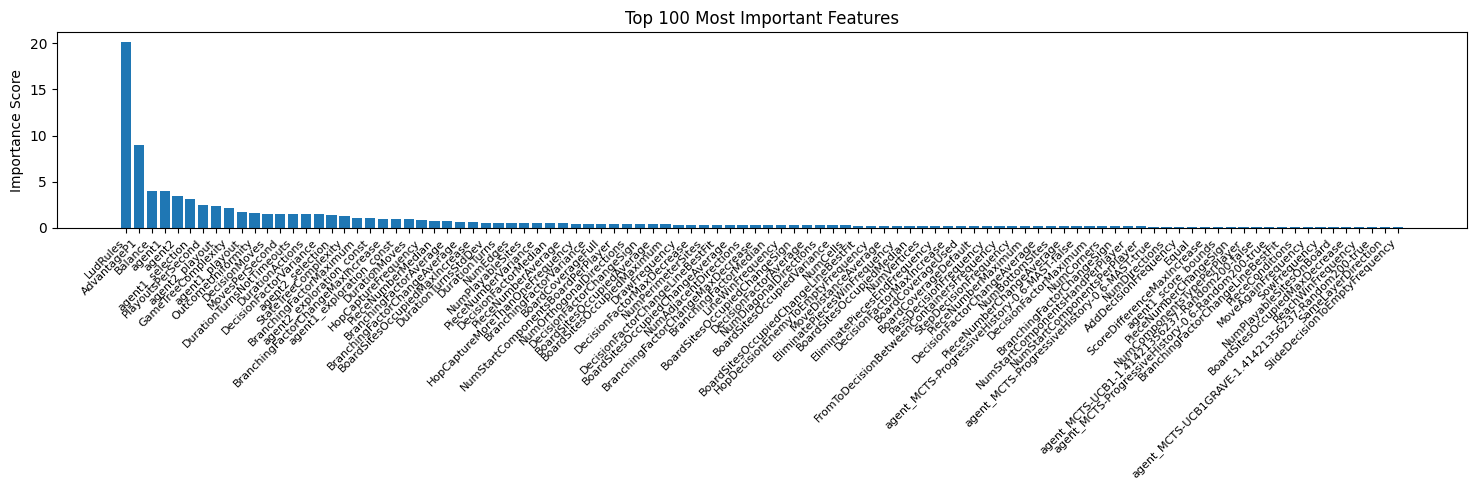

Fold 2 - RMSE: 0.40101897628144
Fold 3
0:	learn: 0.5991957	test: 0.6070698	best: 0.6070698 (0)	total: 510ms	remaining: 25m 30s
50:	learn: 0.3812274	test: 0.4846530	best: 0.4846530 (50)	total: 28.2s	remaining: 27m 11s
100:	learn: 0.3436845	test: 0.4627993	best: 0.4627993 (100)	total: 55.2s	remaining: 26m 23s
150:	learn: 0.3206143	test: 0.4532833	best: 0.4532833 (150)	total: 1m 21s	remaining: 25m 46s
200:	learn: 0.3054430	test: 0.4471905	best: 0.4471905 (200)	total: 1m 48s	remaining: 25m 12s
250:	learn: 0.2944883	test: 0.4438508	best: 0.4438508 (250)	total: 2m 15s	remaining: 24m 45s
300:	learn: 0.2857936	test: 0.4424445	best: 0.4423497 (299)	total: 2m 42s	remaining: 24m 16s
350:	learn: 0.2785421	test: 0.4403814	best: 0.4403814 (350)	total: 3m 9s	remaining: 23m 49s
400:	learn: 0.2720519	test: 0.4392963	best: 0.4392963 (400)	total: 3m 36s	remaining: 23m 21s
450:	learn: 0.2661095	test: 0.4383009	best: 0.4383009 (450)	total: 4m 3s	remaining: 22m 55s
500:	learn: 0.2605516	test: 0.4373031	best

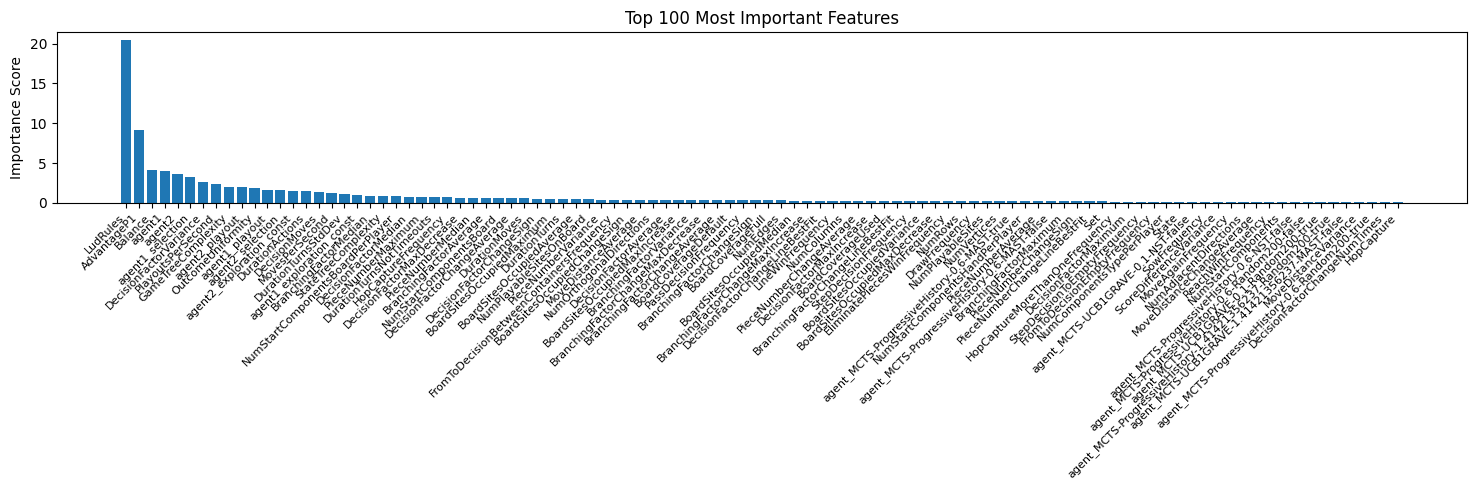

Fold 3 - RMSE: 0.4297215340427581
Fold 4
0:	learn: 0.6020628	test: 0.6004505	best: 0.6004505 (0)	total: 519ms	remaining: 25m 56s
50:	learn: 0.3890680	test: 0.4745558	best: 0.4745558 (50)	total: 30.3s	remaining: 29m 14s
100:	learn: 0.3512080	test: 0.4558902	best: 0.4558902 (100)	total: 59.8s	remaining: 28m 35s
150:	learn: 0.3307825	test: 0.4486057	best: 0.4486057 (150)	total: 1m 29s	remaining: 28m 9s
200:	learn: 0.3143030	test: 0.4432338	best: 0.4432338 (200)	total: 1m 58s	remaining: 27m 36s
250:	learn: 0.3021650	test: 0.4403706	best: 0.4403706 (250)	total: 2m 28s	remaining: 27m 7s
300:	learn: 0.2931262	test: 0.4385632	best: 0.4385593 (299)	total: 2m 58s	remaining: 26m 39s
350:	learn: 0.2852425	test: 0.4372984	best: 0.4372984 (350)	total: 3m 28s	remaining: 26m 12s
400:	learn: 0.2780610	test: 0.4356485	best: 0.4356151 (398)	total: 3m 58s	remaining: 25m 45s
450:	learn: 0.2720322	test: 0.4348492	best: 0.4348256 (449)	total: 4m 28s	remaining: 25m 19s
500:	learn: 0.2668615	test: 0.4340779	be

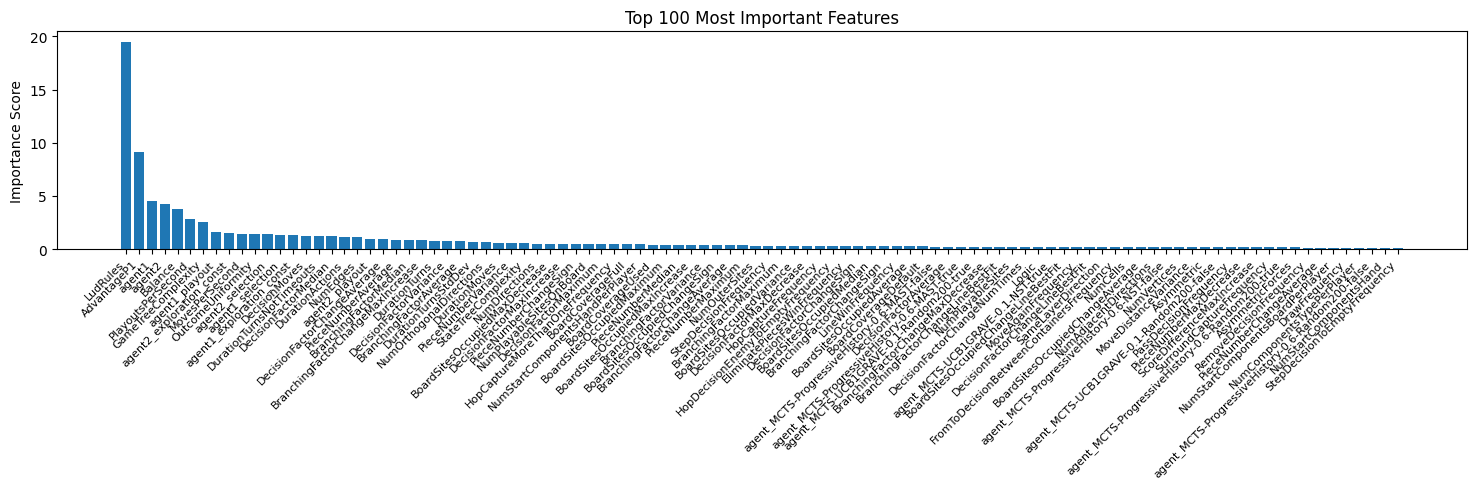

Fold 4 - RMSE: 0.4276322534304065
Fold 5
0:	learn: 0.6039373	test: 0.5838068	best: 0.5838068 (0)	total: 535ms	remaining: 26m 43s
50:	learn: 0.3862120	test: 0.4733266	best: 0.4733266 (50)	total: 28.5s	remaining: 27m 30s
100:	learn: 0.3502212	test: 0.4549832	best: 0.4549832 (100)	total: 57.2s	remaining: 27m 21s
150:	learn: 0.3274447	test: 0.4433938	best: 0.4433938 (150)	total: 1m 25s	remaining: 26m 51s
200:	learn: 0.3118529	test: 0.4379950	best: 0.4379950 (200)	total: 1m 53s	remaining: 26m 21s
250:	learn: 0.3004136	test: 0.4344233	best: 0.4344233 (250)	total: 2m 21s	remaining: 25m 53s
300:	learn: 0.2906485	test: 0.4319208	best: 0.4319208 (300)	total: 2m 49s	remaining: 25m 19s
350:	learn: 0.2823931	test: 0.4298623	best: 0.4298623 (350)	total: 3m 16s	remaining: 24m 44s
400:	learn: 0.2755988	test: 0.4286617	best: 0.4286617 (400)	total: 3m 44s	remaining: 24m 13s
450:	learn: 0.2696383	test: 0.4276675	best: 0.4276672 (448)	total: 4m 11s	remaining: 23m 43s
500:	learn: 0.2647594	test: 0.4265796	

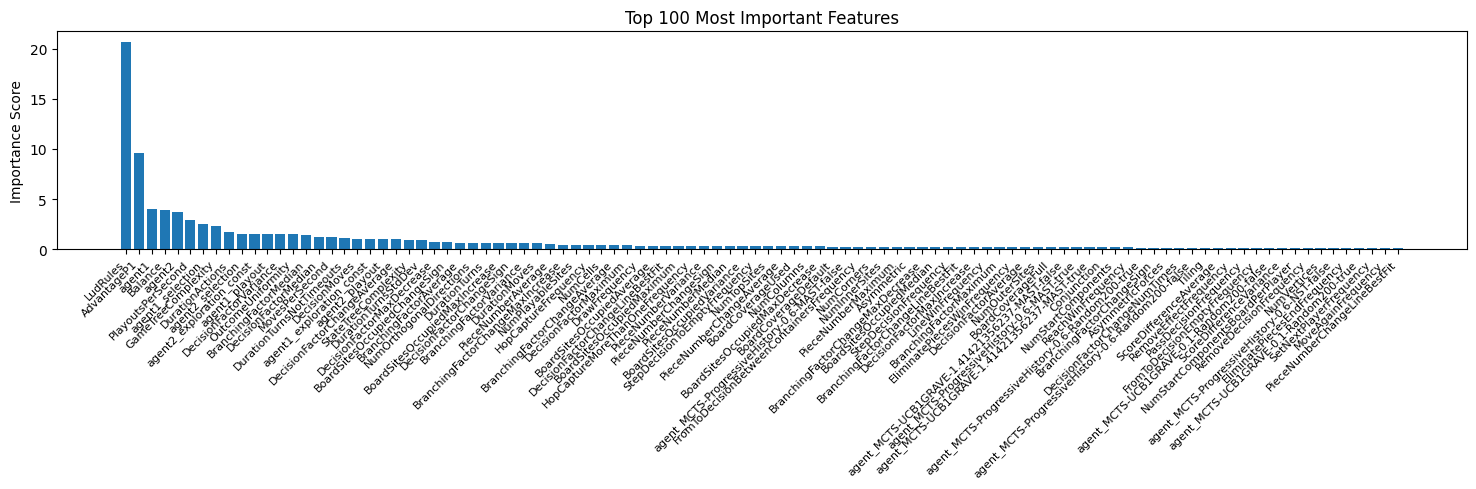

Fold 5 - RMSE: 0.4200664218596014
List of oof scores: [0.40815936282291454, 0.40101897628144, 0.4297215340427581, 0.4276322534304065, 0.4200664218596014]
Average oof score: 0.4173197096874241


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_text_{fs_type}_cv2.parquet', index=False)

Fold 1
0:	learn: 0.6078821	test: 0.5720302	best: 0.5720302 (0)	total: 567ms	remaining: 28m 19s
50:	learn: 0.3898332	test: 0.4602850	best: 0.4602850 (50)	total: 32.8s	remaining: 31m 37s
100:	learn: 0.3514142	test: 0.4422648	best: 0.4422648 (100)	total: 1m 4s	remaining: 30m 49s
150:	learn: 0.3279247	test: 0.4352993	best: 0.4352622 (145)	total: 1m 35s	remaining: 30m 9s
200:	learn: 0.3119434	test: 0.4305321	best: 0.4305321 (200)	total: 2m 7s	remaining: 29m 29s
250:	learn: 0.3000179	test: 0.4275661	best: 0.4275083 (249)	total: 2m 38s	remaining: 28m 53s
300:	learn: 0.2907483	test: 0.4260116	best: 0.4260116 (300)	total: 3m 9s	remaining: 28m 21s
350:	learn: 0.2828002	test: 0.4249112	best: 0.4249112 (350)	total: 3m 41s	remaining: 27m 49s
400:	learn: 0.2760069	test: 0.4238112	best: 0.4237534 (399)	total: 4m 12s	remaining: 27m 18s
450:	learn: 0.2688944	test: 0.4234317	best: 0.4233535 (443)	total: 4m 44s	remaining: 26m 48s
500:	learn: 0.2634456	test: 0.4223979	best: 0.4223937 (494)	total: 5m 16s	r

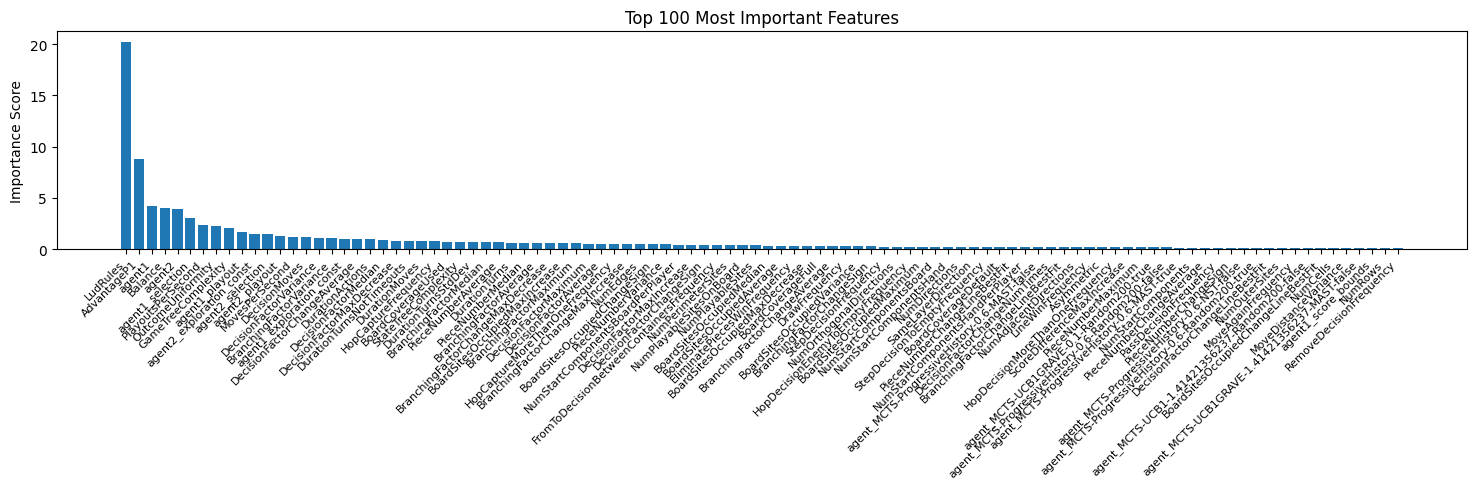

Fold 1 - RMSE: 0.4180655385629207
Fold 2
0:	learn: 0.6060153	test: 0.5662409	best: 0.5662409 (0)	total: 523ms	remaining: 26m 9s
50:	learn: 0.3922715	test: 0.4633763	best: 0.4633763 (50)	total: 29.1s	remaining: 28m 1s
100:	learn: 0.3571122	test: 0.4405387	best: 0.4405387 (100)	total: 57.4s	remaining: 27m 28s
150:	learn: 0.3333651	test: 0.4303567	best: 0.4303567 (150)	total: 1m 25s	remaining: 26m 49s
200:	learn: 0.3176670	test: 0.4242035	best: 0.4242035 (200)	total: 1m 53s	remaining: 26m 19s
250:	learn: 0.3058341	test: 0.4209904	best: 0.4209904 (250)	total: 2m 21s	remaining: 25m 50s
300:	learn: 0.2961634	test: 0.4185906	best: 0.4185906 (300)	total: 2m 49s	remaining: 25m 22s
350:	learn: 0.2880630	test: 0.4164144	best: 0.4164144 (350)	total: 3m 18s	remaining: 24m 54s
400:	learn: 0.2808371	test: 0.4145127	best: 0.4145127 (400)	total: 3m 46s	remaining: 24m 27s
450:	learn: 0.2745782	test: 0.4133337	best: 0.4133143 (449)	total: 4m 14s	remaining: 24m
500:	learn: 0.2690557	test: 0.4124677	best: 

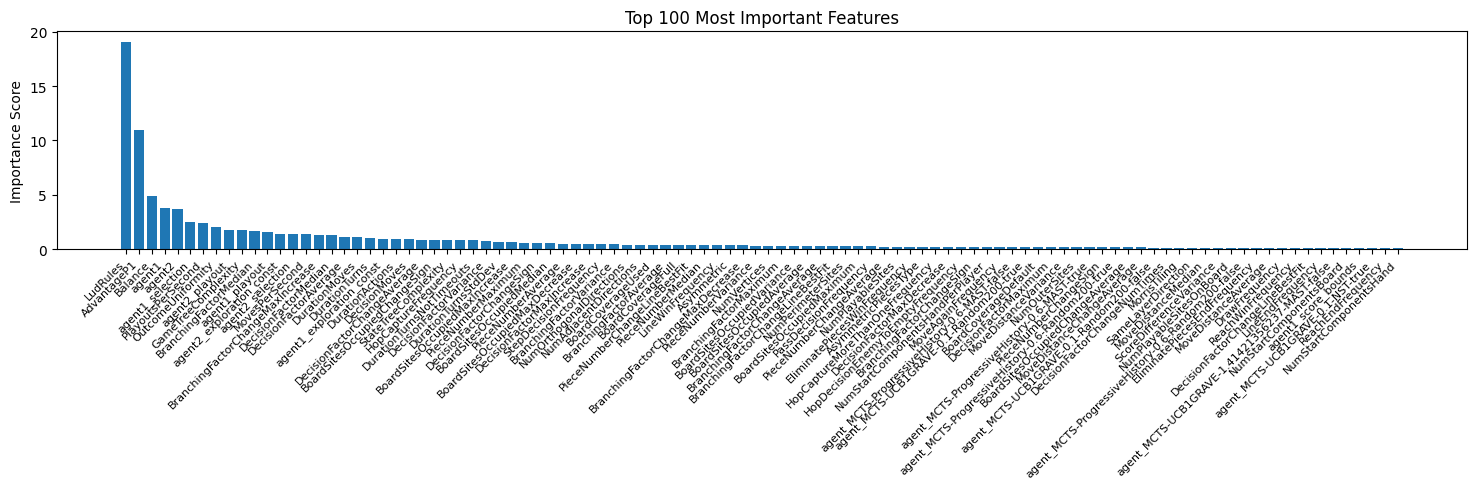

Fold 2 - RMSE: 0.40425673045718113
Fold 3
0:	learn: 0.6084033	test: 0.5672478	best: 0.5672478 (0)	total: 623ms	remaining: 31m 6s
50:	learn: 0.3897229	test: 0.4558720	best: 0.4558720 (50)	total: 29s	remaining: 27m 58s
100:	learn: 0.3528479	test: 0.4372028	best: 0.4372028 (100)	total: 57.4s	remaining: 27m 28s
150:	learn: 0.3292923	test: 0.4289196	best: 0.4289196 (150)	total: 1m 25s	remaining: 26m 51s
200:	learn: 0.3134085	test: 0.4253772	best: 0.4252739 (196)	total: 1m 54s	remaining: 26m 28s
250:	learn: 0.3014933	test: 0.4232563	best: 0.4232514 (249)	total: 2m 22s	remaining: 25m 57s
300:	learn: 0.2922138	test: 0.4211888	best: 0.4211888 (300)	total: 2m 50s	remaining: 25m 31s
350:	learn: 0.2834192	test: 0.4195704	best: 0.4195704 (350)	total: 3m 17s	remaining: 24m 54s
400:	learn: 0.2768246	test: 0.4182904	best: 0.4182904 (400)	total: 3m 47s	remaining: 24m 32s
450:	learn: 0.2708421	test: 0.4175536	best: 0.4174224 (445)	total: 4m 19s	remaining: 24m 24s
500:	learn: 0.2654187	test: 0.4167650	be

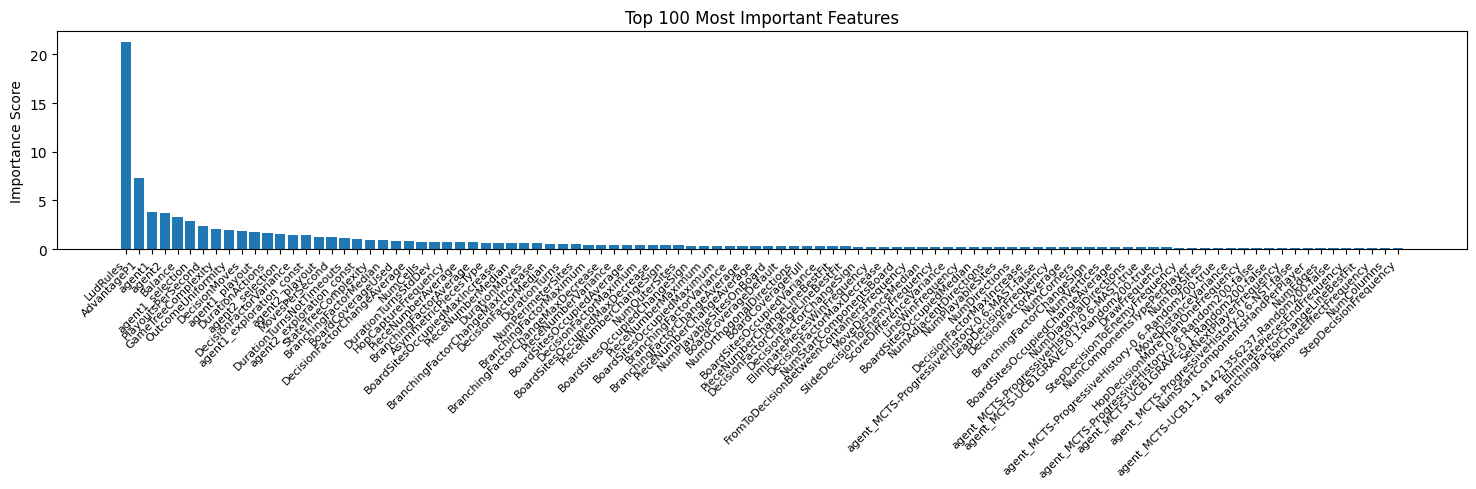

Fold 3 - RMSE: 0.4111277274229401
Fold 4
0:	learn: 0.6088318	test: 0.5683648	best: 0.5683648 (0)	total: 531ms	remaining: 26m 31s
50:	learn: 0.3926753	test: 0.4596460	best: 0.4596460 (50)	total: 28.6s	remaining: 27m 35s
100:	learn: 0.3549350	test: 0.4447610	best: 0.4447610 (100)	total: 56.6s	remaining: 27m 4s
150:	learn: 0.3322480	test: 0.4363837	best: 0.4363837 (150)	total: 1m 24s	remaining: 26m 34s
200:	learn: 0.3159262	test: 0.4309086	best: 0.4309086 (200)	total: 1m 51s	remaining: 25m 59s
250:	learn: 0.3037954	test: 0.4281696	best: 0.4281696 (250)	total: 2m 19s	remaining: 25m 26s
300:	learn: 0.2935306	test: 0.4262505	best: 0.4262317 (299)	total: 2m 46s	remaining: 24m 55s
350:	learn: 0.2851078	test: 0.4239853	best: 0.4239853 (350)	total: 3m 14s	remaining: 24m 29s
400:	learn: 0.2773122	test: 0.4231063	best: 0.4230610 (397)	total: 3m 43s	remaining: 24m 10s
450:	learn: 0.2708613	test: 0.4219325	best: 0.4218685 (441)	total: 4m 11s	remaining: 23m 42s
500:	learn: 0.2652468	test: 0.4211803	b

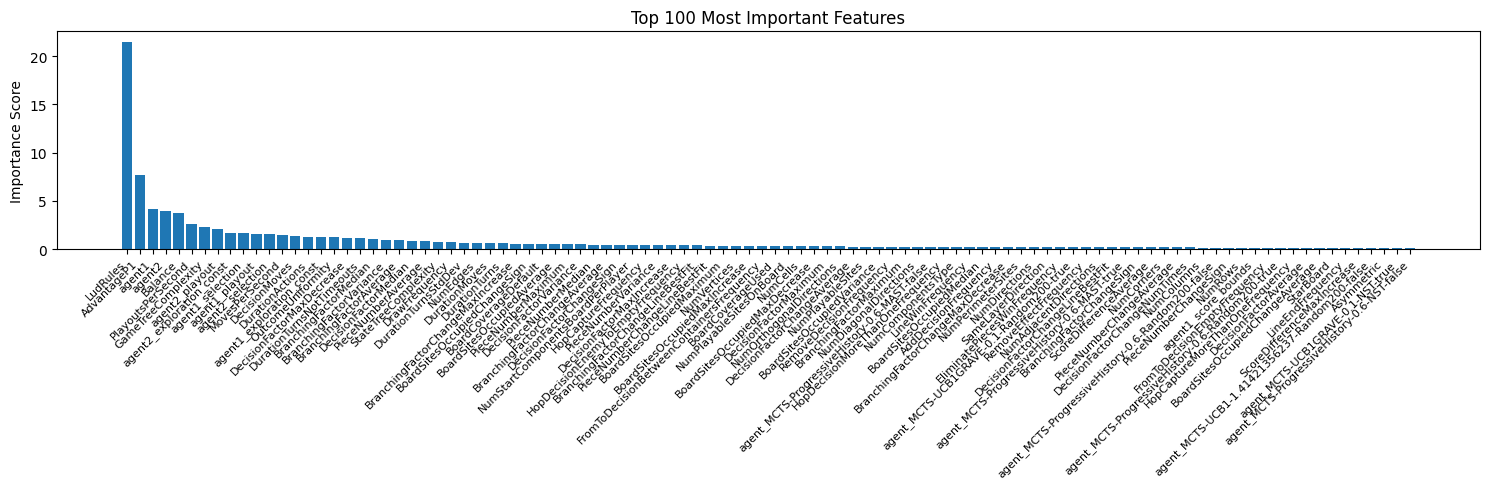

Fold 4 - RMSE: 0.41593277769879566
Fold 5
0:	learn: 0.6044597	test: 0.5804700	best: 0.5804700 (0)	total: 490ms	remaining: 24m 29s
50:	learn: 0.3926278	test: 0.4740554	best: 0.4740554 (50)	total: 28s	remaining: 26m 56s
100:	learn: 0.3553615	test: 0.4530000	best: 0.4530000 (100)	total: 55.6s	remaining: 26m 34s
150:	learn: 0.3341979	test: 0.4438412	best: 0.4438070 (149)	total: 1m 23s	remaining: 26m 10s
200:	learn: 0.3172869	test: 0.4385924	best: 0.4385924 (200)	total: 1m 50s	remaining: 25m 39s
250:	learn: 0.3045338	test: 0.4354262	best: 0.4354262 (250)	total: 2m 17s	remaining: 25m 11s
300:	learn: 0.2946190	test: 0.4328781	best: 0.4328781 (300)	total: 2m 45s	remaining: 24m 46s
350:	learn: 0.2860901	test: 0.4314930	best: 0.4314877 (348)	total: 3m 13s	remaining: 24m 18s
400:	learn: 0.2792456	test: 0.4303441	best: 0.4303075 (399)	total: 3m 40s	remaining: 23m 50s
450:	learn: 0.2729913	test: 0.4293071	best: 0.4292454 (446)	total: 4m 8s	remaining: 23m 22s
500:	learn: 0.2675079	test: 0.4284335	be

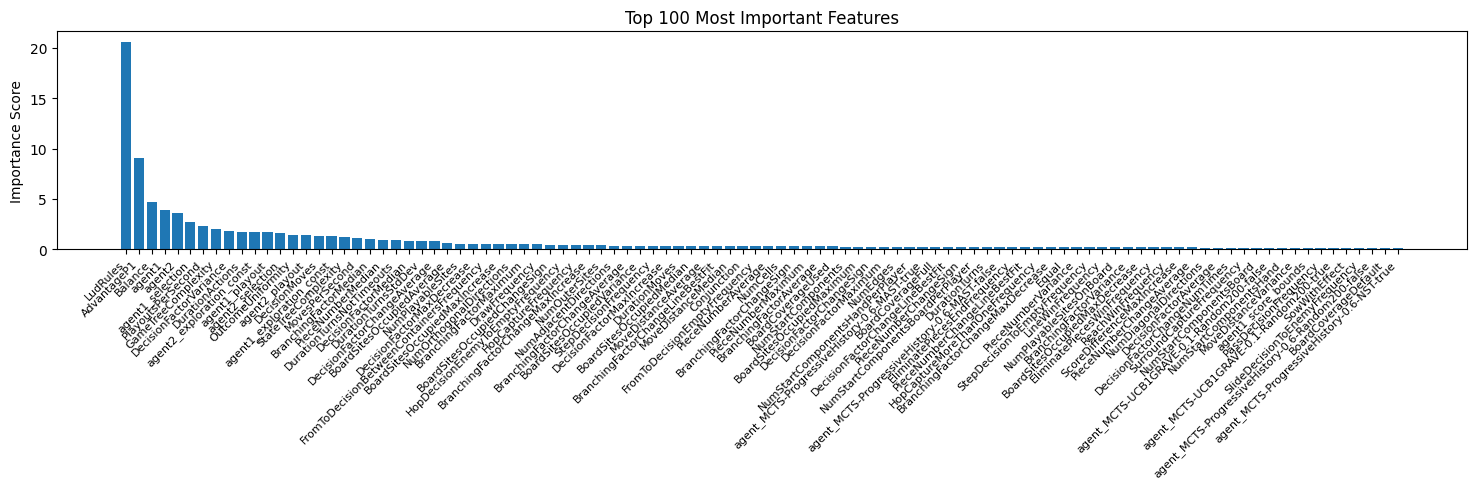

Fold 5 - RMSE: 0.42406758481313206
List of oof scores: [0.4180655385629207, 0.40425673045718113, 0.4111277274229401, 0.41593277769879566, 0.42406758481313206]
Average oof score: 0.414690071790994


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_text_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4200
Score: 0.4390
Score: 0.4200
Score: 0.4283
Score: 0.4031
Average CV1 Score: 0.4221

CV2 OOF Scores:
Score: 0.4082
Score: 0.4010
Score: 0.4297
Score: 0.4276
Score: 0.4201
Average CV2 Score: 0.4173

CV3 OOF Scores:
Score: 0.4181
Score: 0.4043
Score: 0.4111
Score: 0.4159
Score: 0.4241
Average CV3 Score: 0.4147


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

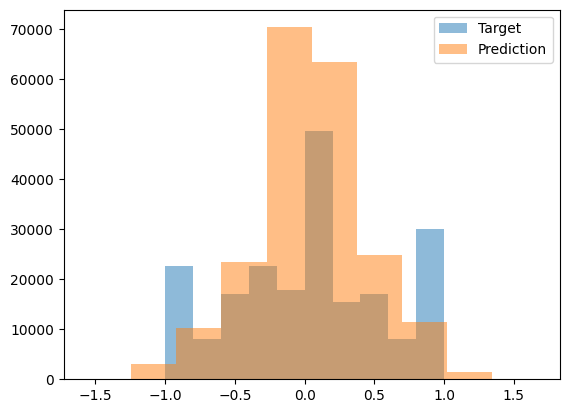

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Prepare data columns
    features = numerical_cols + categorical_cols
    pool_kwargs = {
        'data': test_processed[features],
        'cat_features': categorical_cols,
    }
    
    # Include text columns if they are not None
    if text_cols is not None:
        features += text_cols
        pool_kwargs['data'] = test_processed[features]
        pool_kwargs['text_features'] = text_cols

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(**pool_kwargs)

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.150607       │
│ 233235 ┆ -0.163806      │
│ 233236 ┆ 0.03955        │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_text_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***